In [402]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [403]:
data = pd.read_excel("data/avalon_data.xlsx")

In [418]:
df = data.copy()
df = df.dropna()

## Преобразование данных

In [424]:
def time_to_minutes(time_obj):
    return time_obj.hour * 60 + time_obj.minute + time_obj.second / 60

df['total_inb_time_min'] = df['Время приемки'].apply(time_to_minutes)

In [425]:
df['start_date'] = pd.to_datetime(df['Дата начала разгрузки'] + \
                                        ' ' + df['Время начала разгрузки'], \
                                        format='%d.%m.%Y %H:%M:%S')
df['end_date'] = pd.to_datetime(df['Дата окончания разгрузки'] + \
                                        ' ' + df['Время окончания разгрузки'], \
                                        format='%d.%m.%Y %H:%M:%S')
df['inb_time'] = df['total_inb_time_min'] - (df['end_date'] - df['start_date']).dt.total_seconds() / 60

In [426]:
df

,Склад,Клиент,док №,Номер заказа,Бухгалтерская дата,Дата начала разгрузки,Время начала разгрузки,Дата окончания разгрузки,Время окончания разгрузки,Принято моно-паллет (по этому документу),...,Принято единиц,Время приемки,Unnamed: 15,1,Unnamed: 17,минуты,total_inb_time_min,start_date,end_date,inb_time
0,771,Вода,9848422,0186804531,03.01.2025,03.01.2025,09:05:49,03.01.2025,09:12:26,27,...,0.0,00:36:37,0,00:30:00,00:06:37,36.616667,36.616667,2025-01-03 09:05:49,2025-01-03 09:12:26,30.0
1,771,Вода,9848422,0186804531,03.01.2025,03.01.2025,09:05:49,03.01.2025,09:12:26,27,...,0.0,00:36:37,0,00:30:00,00:06:37,36.616667,36.616667,2025-01-03 09:05:49,2025-01-03 09:12:26,30.0
2,771,Вода,9848422,0186804531,03.01.2025,03.01.2025,09:05:49,03.01.2025,09:12:26,27,...,0.0,00:36:37,0,00:30:00,00:06:37,36.616667,36.616667,2025-01-03 09:05:49,2025-01-03 09:12:26,30.0
3,771,Вода,9848422,0186804531,03.01.2025,03.01.2025,09:05:49,03.01.2025,09:12:26,27,...,0.0,00:36:37,0,00:30:00,00:06:37,36.616667,36.616667,2025-01-03 09:05:49,2025-01-03 09:12:26,30.0
4,771,Вода,9848422,0186804531,03.01.2025,03.01.2025,09:05:49,03.01.2025,09:12:26,27,...,0.0,00:36:37,0,00:30:00,00:06:37,36.616667,36.616667,2025-01-03 09:05:49,2025-01-03 09:12:26,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33522,771,Вода,10657684,0207305405,30.08.2025,30.08.2025,15:49:21,30.08.2025,16:09:45,26,...,0.0,00:50:24,0,00:30:00,00:20:24,50.400000,50.400000,2025-08-30 15:49:21,2025-08-30 16:09:45,30.0
33523,771,Вода,10657684,0207305405,30.08.2025,30.08.2025,15:49:21,30.08.2025,16:09:45,26,...,0.0,00:50:24,0,00:30:00,00:20:24,50.400000,50.400000,2025-08-30 15:49:21,2025-08-30 16:09:45,30.0
33524,771,Вода,10657684,0207305405,30.08.2025,30.08.2025,15:49:21,30.08.2025,16:09:45,26,...,0.0,00:50:24,0,00:30:00,00:20:24,50.400000,50.400000,2025-08-30 15:49:21,2025-08-30 16:09:45,30.0
33525,771,Вода,10658109,0187559305,30.08.2025,30.08.2025,22:16:51,30.08.2025,22:19:08,29,...,0.0,00:32:17,0,00:30:00,00:02:17,32.283333,32.283333,2025-08-30 22:16:51,2025-08-30 22:19:08,30.0


In [399]:
df_clean = df.drop(['Бухгалтерская дата', 
                    'док №',
                   'Клиент',
                   'Артикул',
                   'Склад',
                   'Принято единиц',
                    'Принято упаковок',
                   'Дата начала разгрузки',
                   'Время начала разгрузки',
                   'Дата окончания разгрузки',
                   'Время окончания разгрузки'], axis=1)

In [400]:
df_clean.head(1)

,Номер заказа,Принято моно-паллет (по этому документу),Группа,Время приемки,Unnamed: 15,1,Unnamed: 17,start_date,end_date,inb_time
0,0186804531,27,Снеки,00:36:37,0,00:30:00,00:06:37,2025-01-03 09:05:49,2025-01-03 09:12:26,6.616667


In [365]:
df_final = df_clean.groupby(['Номер заказа', 'inb_time', \
                       'Принято моно-паллет (по этому документу)', \
                       'start_date', \
                      'end_date']).agg({
    'Группа': ['nunique'] # уникальные значения и сумма
}).reset_index()

df_final.columns = ['Номер заказа', 'inb_time', 'Принято моно-паллет', \
                    'start_date', 'end_date', 
                    'Кол-во категорий']

In [394]:
len(df_final)

7677

In [366]:
df_final['start_hour'] = df_final['start_date'].dt.hour
df_final['start_week'] = df_final['start_date'].dt.isocalendar().week
df_final['start_weekday'] = df_final['start_date'].dt.weekday

In [367]:
## временные переводим в циклические
df_final['start_hour_sin'] = np.sin(2 * np.pi * df_final['start_hour'] / 24)
df_final['start_hour_cos'] = np.cos(2 * np.pi * df_final['start_hour'] / 24)

df_final['start_week_sin'] = np.sin(2 * np.pi * df_final['start_week'] / 7)
df_final['start_week_cos'] = np.cos(2 * np.pi * df_final['start_week'] / 7)

df_final['start_weekday_sin'] = np.sin(2 * np.pi * df_final['start_weekday'] / 52)
df_final['start_weekday_cos'] = np.cos(2 * np.pi * df_final['start_weekday'] / 52)

In [368]:
df_final

,Номер заказа,inb_time,Принято моно-паллет,start_date,end_date,Кол-во категорий,start_hour,start_week,start_weekday,start_hour_sin,start_hour_cos,start_week_sin,start_week_cos,start_weekday_sin,start_weekday_cos
0,,4.983333,31,2025-05-19 12:42:55,2025-05-19 12:47:54,1,12,21,0,1.224647e-16,-1.000000e+00,-0.0,1.0,0.000000,1.000000
1,0183246650,6.850000,33,2025-07-26 09:55:43,2025-07-26 10:02:34,1,9,30,5,7.071068e-01,-7.071068e-01,0.974928,-0.222521,0.568065,0.822984
2,0183302687,3.716667,28,2025-08-21 22:09:46,2025-08-21 22:13:29,1,22,34,3,-5.000000e-01,8.660254e-01,-0.781831,0.62349,0.354605,0.935016
3,0183309166,7.316667,33,2025-02-24 09:21:27,2025-02-24 09:28:46,1,9,9,0,7.071068e-01,-7.071068e-01,0.974928,-0.222521,0.000000,1.000000
4,0183318143,2.500000,25,2025-08-18 04:18:39,2025-08-18 04:21:09,1,4,34,0,8.660254e-01,5.000000e-01,-0.781831,0.62349,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8076,Стойки 51,0.000000,27,2025-08-19 08:21:07,2025-08-19 08:21:07,1,8,34,1,8.660254e-01,-5.000000e-01,-0.781831,0.62349,0.120537,0.992709
8077,Стойки 6,0.000000,38,2025-03-08 18:44:32,2025-03-08 18:44:32,1,18,10,5,-1.000000e+00,-1.836970e-16,0.433884,-0.900969,0.568065,0.822984
8078,Стойки 7,0.000000,27,2025-03-10 09:26:03,2025-03-10 09:26:03,1,9,11,0,7.071068e-01,-7.071068e-01,-0.433884,-0.900969,0.000000,1.000000
8079,Стойки 8,0.000000,45,2025-03-12 14:22:18,2025-03-12 14:22:18,1,14,11,2,-5.000000e-01,-8.660254e-01,-0.433884,-0.900969,0.239316,0.970942


In [369]:
##удаляем выбросы 
percentile_99_dur = df_final['inb_time'].quantile(0.95)
df_final['is_extreme_dur'] = (df_final['inb_time'] > percentile_99_dur).astype(int)
df_final = df_final[df_final['is_extreme_dur'] == 0]

## Деление выборки

In [370]:
x = df_final.drop(['inb_time'], axis=1)
y = df_final['inb_time']

Логарифмирование 

In [371]:
y_log = np.log1p(y)

In [372]:
x_train, x_test, y_train_log, y_test_log = train_test_split(
    x , y_log, test_size=0.2, random_state=42, stratify=None
)

In [373]:
test_indices = x_test.index

In [374]:
len(x_test)

1536

In [375]:
def handle_missing_data(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna('Unknown', inplace=True)
    
    return df

In [376]:
def encode_categorical_features(df):
    le = LabelEncoder()
    categorical_cols = df.select_dtypes(include=['object']).columns
    
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    
    return df

In [377]:
x_test.dtypes

Номер заказа                   object
Принято моно-паллет             int64
start_date             datetime64[ns]
end_date               datetime64[ns]
Кол-во категорий                int64
start_hour                      int32
start_week                     UInt32
start_weekday                   int32
start_hour_sin                float64
start_hour_cos                float64
start_week_sin                Float64
start_week_cos                Float64
start_weekday_sin             float64
start_weekday_cos             float64
is_extreme_dur                  int64
dtype: object

In [378]:
x_test = handle_missing_data(x_test)
x_test = encode_categorical_features(x_test)

x_train = handle_missing_data(x_train)
x_train = encode_categorical_features(x_train)

In [379]:
def drop_colums(df):
    df = df.drop(['start_hour','start_week',\
                          'start_weekday','end_date',\
                         'Номер заказа','start_date'], axis=1)
    return df

In [380]:
x_test = drop_colums(x_test)
x_train = drop_colums(x_train)

In [381]:
x_train

,Принято моно-паллет,Кол-во категорий,start_hour_sin,start_hour_cos,start_week_sin,start_week_cos,start_weekday_sin,start_weekday_cos,is_extreme_dur
524,25,1,0.500000,0.866025,-0.0,1.0,0.354605,0.935016,0
3195,32,1,-0.707107,0.707107,-0.0,1.0,0.568065,0.822984,0
4878,27,1,-0.707107,-0.707107,-0.781831,0.62349,0.568065,0.822984,0
2528,26,1,0.707107,-0.707107,0.781831,0.62349,0.239316,0.970942,0
1600,30,1,0.707107,-0.707107,0.781831,0.62349,0.464723,0.885456,0
...,...,...,...,...,...,...,...,...,...
5417,25,1,-0.866025,0.500000,-0.974928,-0.222521,0.354605,0.935016,0
5585,32,1,-0.500000,0.866025,-0.0,1.0,0.239316,0.970942,0
896,33,1,-0.866025,0.500000,-0.433884,-0.900969,0.000000,1.000000,0
8003,26,2,-0.707107,-0.707107,-0.0,1.0,0.568065,0.822984,0


In [382]:
y_train_log

524     2.189790
3195    1.783391
4878    1.554630
2528    2.077356
1600    1.853690
          ...   
5417    1.504077
5585    1.609438
896     1.561647
8003    3.063391
7629    0.633043
Name: inb_time, Length: 6141, dtype: float64

## Обучение модели

In [383]:
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)

In [384]:
params = {
    'boosting_type': 'gbdt',          # тип бустинга
    'objective': 'huber',        # задача регрессии
    'verbosity': -1,
    'metric': 'mae',                  # метрика - средняя абсолютная ошибка
    'num_leaves': 24,                 # максимальное количество листьев в дереве
    'learning_rate': 0.03,            # скорость обучения
    'feature_fraction': 0.9,          # доля признаков для использования на каждой итерации
    'bagging_fraction': 0.8,          # доля данных для использования на каждой итерации
    'bagging_freq': 5,                # частота bagging
    'verbose': 0,                     # уровень детализации вывода
    'random_state': 42,               # для воспроизводимости
    'n_estimators': 2000,             # количество деревьев
    'max_depth': -1,                  # глубина деревьев (-1 = без ограничений)
    'min_data_in_leaf': 25,           # минимальное количество данных в листе
    'alpha': 0.9
}

In [385]:
train_data = lgb.Dataset(x_train, label=y_train_log)
test_data = lgb.Dataset(x_test, label=y_test_log, reference=train_data)

In [386]:
# Обучение модели с ранней остановкой
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[test_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	valid_0's l1: 0.339723
[200]	valid_0's l1: 0.331527
[300]	valid_0's l1: 0.330439
[400]	valid_0's l1: 0.330061
Early stopping, best iteration is:
[380]	valid_0's l1: 0.329892


In [387]:
y_pred_log = model.predict(x_test)

In [388]:
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

In [389]:
# Метрики качества
print(f"MAE (Средняя абсолютная ошибка): {mean_absolute_error(y_test, y_pred):.2f} минут")
print(f"MSE (Средняя квадратичная ошибка): {mean_squared_error(y_test, y_pred):.2f}")
print(f"RMSE (Корень из MSE): {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} минут")
print(f"R² (Коэффициент детерминации): {r2_score(y_test, y_pred):.4f}")

MAE (Средняя абсолютная ошибка): 2.43 минут
MSE (Средняя квадратичная ошибка): 15.76
RMSE (Корень из MSE): 3.97 минут
R² (Коэффициент детерминации): 0.2642


## Важность признаков

In [390]:
# 8. ВАЖНОСТЬ ПРИЗНАКОВ
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': model.feature_importance()
}).sort_values('importance', ascending=False)

print("\nТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:")
print(feature_importance.head(15))


ТОП-15 ВАЖНЕЙШИХ ПРИЗНАКОВ:
               feature  importance
0  Принято моно-паллет        2223
4       start_week_sin        1727
2       start_hour_sin        1230
3       start_hour_cos        1088
5       start_week_cos        1069
6    start_weekday_sin        1039
1     Кол-во категорий         268
7    start_weekday_cos          96
8       is_extreme_dur           0


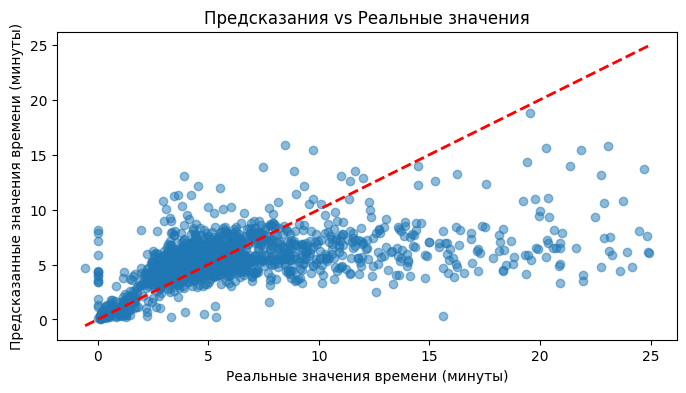

In [391]:
# 9. ВИЗУАЛИЗАЦИЯ ПРЕДСКАЗАНИЙ vs РЕАЛЬНЫЕ ЗНАЧЕНИЯ
plt.figure(figsize=(8, 4))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Реальные значения времени (минуты)')
plt.ylabel('Предсказанные значения времени (минуты)')
plt.title('Предсказания vs Реальные значения')
plt.show()

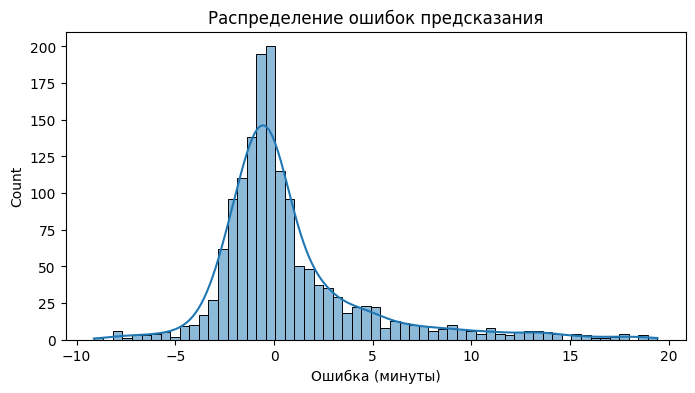

In [392]:
# 10. АНАЛИЗ ОШИБОК
errors = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(errors, kde=True)
plt.title('Распределение ошибок предсказания')
plt.xlabel('Ошибка (минуты)')
plt.show()

In [393]:
# Создаем DataFrame с результатами
#results_df = x_test.copy()
results_df = df_final.loc[test_indices].copy()

# Добавляем предсказания и фактические значения
results_df['predicted_time'] = y_pred
results_df['actual_time'] = y_test

# Вычисляем ошибку
results_df['error'] = results_df['predicted_time'] - results_df['actual_time']

# Сохраняем в CSV
results_df.to_csv('predictions_results_receipt.csv', index=False, encoding='utf-8-sig')

print("Файл сохранен: predictions_results_receipt.csv")
print(f"Количество строк: {len(results_df)}")

Файл сохранен: predictions_results_receipt.csv
Количество строк: 1536
